In [310]:
import numpy as np
import pandas as pd 
import scipy.special as spsp
import scipy.stats as spst
import matplotlib.pyplot as plt

from statsmodels.formula.api import logit, mnlogit
from statsmodels.tools.tools import add_constant
from statsmodels.base.model import GenericLikelihoodModel

In [311]:
pip install numpy pandas scipy statsmodels matplotlib scikit-learn

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Setting

We will be looking at a data set from [NYC OpenData](https://data.cityofnewyork.us/Business/License-Applications/ptev-4hud/about_data) that describes license applications submitted to the NYC Department of Consumer and Worker Protection. We will model both the timing and outcome of the license decisions made by the department. 

The columns of interest for us will be the following:
* **Status**: `Issued`, `Denied`, `Pending`, or `Withdrawn`.
* **LicenseType**: `Business` or `Individual`.
* **ApplicationType**: `Application` or `Renewal`.
* **ApplicationCategory**: `Basic` or `Special`.

Before we proceed, we will add one more column to the dataframe. **days** will simply be the number of days between an application's submission and final decision. There are a few rows where **days** will turn out negative, so we will drop those. Finally, there are a few applications for which **days** is very large or missing, the latter due to a missing end date. We will **right-censor these at $t=50$**.


In [312]:
License = pd.read_csv("Archived_License_Applications.csv")
License = License.astype({"StartDate": "datetime64[ns]", "EndDate": "datetime64[ns]"})
License = License.assign(days=(License["EndDate"]-License["StartDate"]).dt.days+1)

License = License[License["days"] >= 1]
License.loc[License["days"] > 50, "days"] = 50
License["days"].fillna(50)
License

,ApplicationID,LicenseNumber,LicenseType,ApplicationType,Business Name,Status,StartDate,EndDate,LicenseCategory,ApplicationCategory,days
0,1066-2017-RHIC,1294131-DCA,Business,Renewal,PEYKO TZENOV,Issued,2017-01-09,2017-01-10,Home Improvement Contractor,Special,2.0
1,7066-2014-ASLS,2009515-DCA,Business,Application,7TH AVE GOURMET INC.,Issued,2014-06-02,2014-06-13,Stoop Line Stand,Basic,12.0
2,1164-2019-RDPD,1472251-DCA,Business,Renewal,AMERICAN EAST PHARMACY INC.,Issued,2019-01-09,2019-01-10,Dealer In Products,Basic,2.0
3,33701-2016-RELE,2025971-DCA,Business,Renewal,LUCAS ELECTRONICS INC,Issued,2016-12-31,2017-01-10,Electronics Store,Basic,11.0
4,34278-2018-RELE,2047043-DCA,Business,Renewal,ELITE WIRELESS GROUP NY LLC,Issued,2018-12-31,2019-01-08,Electronics Store,Basic,9.0
...,...,...,...,...,...,...,...,...,...,...,...
9994,33141-2019-RTRD,1251607-DCA,Business,Renewal,"25TH ASTORIA BAGEL & PIZZA, INC.",Issued,2019-11-20,2019-11-21,Tobacco Retail Dealer,Basic,2.0
9995,32766-2019-RGEV,2021376-DCA,Individual,Renewal,"SPOONER, CELESTINE",Issued,2019-11-18,2019-11-18,General Vendor,Special,1.0
9996,19840-2019-RSHA,1120632-DCA,Business,Renewal,"LONG LIFE TRUCK & AUTO SPRING CO., INC.",Issued,2019-05-15,2019-05-16,Secondhand Dealer - Auto,Basic,2.0
9997,12661-2016-APSI,NaN,Individual,Application,LINDA BROADWAY,Denied,2016-09-08,2016-09-17,Process Server Individual,Basic,10.0


# Part 1 [14 pts]

Estimate a 2-segment mixture model to predict the number of **days** for a decision to be made on an application. Segment 1 will be an exponential distribution ($c=1$) with parameter $\lambda_1$, and segment 2 will be a Weibull distribution with parameters $c$ and $\lambda_2$.

The three parameters above will be constant, but we will let the probability $p$ depend on each of the three covariates. Let the `Individual` **LicenseType**, `Renewal` **ApplicationType**, and `Special` **ApplicationCategory** correspond to value 1, and the alternative values correspond to value 0. You should thus be estimating **seven** parameters in total.

You can define a design matrix $X$ containing 0/1 values over the three covariate columns as described. Be sure to use the appropriate censored likelihoods. Show the model summary when finished.

In [313]:
License['LT_Ind'] = (License['LicenseType'] == 'Individual').astype(int)
License['LT_Ind']

0       0
1       0
2       0
3       0
4       0
       ..
9994    0
9995    1
9996    0
9997    1
9998    0
Name: LT_Ind, Length: 9887, dtype: int64

In [314]:
License['AT_Re'] = (License['ApplicationType'] == 'Renewal').astype(int)
License['AC_Spe'] = (License['ApplicationCategory'] == 'Special').astype(int)
License

,ApplicationID,LicenseNumber,LicenseType,ApplicationType,Business Name,Status,StartDate,EndDate,LicenseCategory,ApplicationCategory,days,LT_Ind,AT_Re,AC_Spe
0,1066-2017-RHIC,1294131-DCA,Business,Renewal,PEYKO TZENOV,Issued,2017-01-09,2017-01-10,Home Improvement Contractor,Special,2.0,0,1,1
1,7066-2014-ASLS,2009515-DCA,Business,Application,7TH AVE GOURMET INC.,Issued,2014-06-02,2014-06-13,Stoop Line Stand,Basic,12.0,0,0,0
2,1164-2019-RDPD,1472251-DCA,Business,Renewal,AMERICAN EAST PHARMACY INC.,Issued,2019-01-09,2019-01-10,Dealer In Products,Basic,2.0,0,1,0
3,33701-2016-RELE,2025971-DCA,Business,Renewal,LUCAS ELECTRONICS INC,Issued,2016-12-31,2017-01-10,Electronics Store,Basic,11.0,0,1,0
4,34278-2018-RELE,2047043-DCA,Business,Renewal,ELITE WIRELESS GROUP NY LLC,Issued,2018-12-31,2019-01-08,Electronics Store,Basic,9.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,33141-2019-RTRD,1251607-DCA,Business,Renewal,"25TH ASTORIA BAGEL & PIZZA, INC.",Issued,2019-11-20,2019-11-21,Tobacco Retail Dealer,Basic,2.0,0,1,0
9995,32766-2019-RGEV,2021376-DCA,Individual,Renewal,"SPOONER, CELESTINE",Issued,2019-11-18,2019-11-18,General Vendor,Special,1.0,1,1,1
9996,19840-2019-RSHA,1120632-DCA,Business,Renewal,"LONG LIFE TRUCK & AUTO SPRING CO., INC.",Issued,2019-05-15,2019-05-16,Secondhand Dealer - Auto,Basic,2.0,0,1,0
9997,12661-2016-APSI,NaN,Individual,Application,LINDA BROADWAY,Denied,2016-09-08,2016-09-17,Process Server Individual,Basic,10.0,1,0,0


In [315]:
X = License[['LT_Ind', 'AT_Re', 'AC_Spe']]
X

,LT_Ind,AT_Re,AC_Spe
0,0,1,1
1,0,0,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
9994,0,1,0
9995,1,1,1
9996,0,1,0
9997,1,0,0


In [316]:
import statsmodels.api as sm
X = sm.add_constant(X)
X

,const,LT_Ind,AT_Re,AC_Spe
0,1.0,0,1,1
1,1.0,0,0,0
2,1.0,0,1,0
3,1.0,0,1,0
4,1.0,0,1,0
...,...,...,...,...
9994,1.0,0,1,0
9995,1.0,1,1,1
9996,1.0,0,1,0
9997,1.0,1,0,0


In [317]:
class Mix_Model(GenericLikelihoodModel):
    def loglike(self, params):
        y, X = self.endog, self.exog 
        lambda1, lambda2, c2 = np.exp(params[4:7])
        beta = params[0:4]
        uncensor = (y < 50).astype(int)
        censor = 1 - uncensor
        p = 1 / (1 + np.exp(-X @ beta))

        #uncensored = (censor == 1)
        #censored = (censor == 0)
        
        #ll1_un = lambda1 * np.exp(-lambda1 * y[uncensored])
        Ft1 = spst.weibull_min.cdf(y, c = 1, scale= lambda1 ** (-1))
        #ll1_cen = 1 - np.exp(-lambda1 * y[censored])
        #ll1_cen = spst.weibull_min.cdf(y, c = 1, scale=lambda1 ** (-lambda1/1))

        Ftm1 = spst.weibull_min.cdf(y - 1, c = 1, scale = lambda1 ** (-1))

        #Ftm1_cen = spst.weibull_min.cdf(y[censored] - 1, c = 1, scale = lambda1 ** (-lambda1/1))


        #ll2_un = (c2 / lambda2) * (y[uncensored] / lambda2) ** (c2-1) * np.exp(-(y[uncensored] / lambda2) ** c2)
        Ft2 = spst.weibull_min.cdf(y, c = c2, scale=lambda2 ** (-1/c2))

        #ll2_cen = 1 - np.exp(-(y[censored] / lambda2) ** c2)
        #ll2_cen = spst.weibull_min.cdf(y, c = c2, scale=lambda2 ** (-lambda2/c2))

        Ftm2 = spst.weibull_min.cdf(y - 1, c = c2, scale = lambda2 ** (-1/c2))

        likelihood1 = Ft1 - Ftm1
        likelihood2 = Ft2 - Ftm2
        

        #Ftm2_cen = spst.weibull_min.cdf(y[censored] - 1, c = c2, scale = lambda2 ** (-lambda2/c2))
        likelihood_un = (1 - censor) * (Ft1 - Ftm1) + censor * (1-Ft1)
        likelihood_cen = (1 - censor) * (Ft2 - Ftm2) + censor * (1-Ft2)
        llMix_final = p * likelihood_un + (1 - p) * likelihood_cen
        #likelihood_un = (1 - censor) * (p * likelihood1 + (1 - p) * likelihood2)
        #likelihood_cen = censor * (p * (1 - Ft1) * (1 - p) * (1 - Ft2))
        #llMix_final = likelihood_cen + likelihood_un




        #llMix_un = censor * (p * (Ft2 - Ftm2_un) + (1 - p) * (Ft1 - Ftm1))
        #llMix_cen = (1-censor) * (p * (1 - Ft2) + (1 - p) * (1 - Ft1))

# 


        #llMix_un = p[uncensored] * ll1_un + (1 - p[uncensored]) * ll2_un
        #llMix_cen = p[censored] * (1 - ll1_cen) + (1 - p[censored]) * (1 - ll2_cen)
        #llMix_final = llMix_un + llMix_cen
        return np.sum(np.log(llMix_final)) 

        #return np.sum(np.log(llMix_un)) + np.sum(np.log(llMix_cen))

In [318]:
class Mix_Model2(GenericLikelihoodModel):
    def loglike(self, params):
        y, X = self.endog, self.exog 
        lambda1, lambda2, c2 = np.exp(params[4:7])
        beta = params[0:4]
        uncensor = (y < 50).astype(int)
        censor = 1 - uncensor
        p = np.exp(X @ beta) / (1 + np.exp(X @ beta))

        Ft1 = spst.weibull_min.cdf(y, c = 1, scale= lambda1 ** (-1))

        Ftm1 = spst.weibull_min.cdf(y - 1, c = 1, scale = lambda1 ** (-1))

        Ft2 = spst.weibull_min.cdf(y, c = c2, scale=lambda2 ** (-1/c2))
        Ftm2 = spst.weibull_min.cdf(y - 1, c = c2, scale = lambda2 ** (-1/c2))

        likelihood_un = (1 - censor) * (Ft1 - Ftm1) + censor * (1-Ft1)
        likelihood_cen = (1 - censor) * (Ft2 - Ftm2) + censor * (1-Ft2)
        llMix_final = p * likelihood_un + (1 - p) * likelihood_cen

        return np.sum(np.log(llMix_final)) 



In [319]:
Model = Mix_Model(License["days"], X).fit(start_params=-np.random.random(7), method="bfgs")
#intercept = 0.638
# beta1 = 0.6927
Model.summary(xname=["Intercept", "Individual", "Renewal", "Special", "lambda_exp", "c_wei", "lambda_wei"])

Optimization terminated successfully.
         Current function value: 2.478840
         Iterations: 45
         Function evaluations: 48
         Gradient evaluations: 48


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:2750: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:2754: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Mix_Model Results                               
==============================================================================
Dep. Variable:                   days   Log-Likelihood:                -24508.
Model:                      Mix_Model   AIC:                         4.903e+04
Method:            Maximum Likelihood   BIC:                         4.908e+04
Date:                Mon, 21 Oct 2024                                         
Time:                        21:32:03                                         
No. Observations:                9887                                         
Df Residuals:                    9883                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0638      0.088      0.726      0.468      -0.108       0.236
Individual     0.6926      0.093      7.411      0.000       0.509       0.876
Renewal        2.0190      0.078     25.798      0.000       1.866       2.172
Special       -0.5386      0.074     -7.259      0.000      -0.684      -0.393
lambda_exp    -0.8293      0.017    -47.775      0.000      -0.863      -0.795
c_wei         -3.0410      0.133    -22.923      0.000      -3.301      -2.781
lambda_wei    -0.0428      0.033     -1.301      0.193      -0.107       0.022
==============================================================================
"""

# Part 2 [12 pts]

Let's try to understand the model we just estimated. 

* Generate two figures, the first showing both segments' interval-censored probabilities as separate curves, and the second showing both segments' interval-censored hazard functions. Use circle markers to indicate the integer values, and plot in the range $t=1$ to $20$.

* Give a brief, qualitative description for what the two segments may represent in the license application pool. What can we conclude from the relative shapes of the hazard functions?

* Looking at the estimated $\hat\beta$ parameters, what combination of features would an application have to have the highest probability of being in segment 1? Compute the corresponding probability. Then answer the same questions for segment 2.

* Consider an application for a `New`, `Basic`, `Business` license. What is the probability that this application belongs to segment 1? What is the probability that this application belongs to segment 1, *given* that this it is approved on day 7?

In [320]:
params = Model.params
lambda1, lambda2, c2 = np.exp(params[4:7])
beta = params[0:4]

In [321]:
lambda1, lambda2, c2

(0.43635253013583153, 0.04778576037708536, 0.9581392566150299)

In [334]:
t = np.arange(1, 20)
F1 = 1 - np.exp(-lambda1 * t)
F1m = 1 - np.exp(-lambda1 * (t - 1))
ll1 = F1 - F1m

#F2 = 1 - np.exp(- (t / lambda2) ** c2)
#F2m = 1 - np.exp(- ((t-1) / lambda2) ** c2)
#ll2 = F2 - F2m

F2 = spst.weibull_min.cdf(t, c2, scale=lambda2**(-1/c2))
F2m = spst.weibull_min.cdf(t-1, c2, scale=lambda2**(-1/c2))
ll2 = F2-F2m

hazard1 = (F1-F1m) / (1-F1m)
hazard2 = (F2-F2m) / (1-F2m)

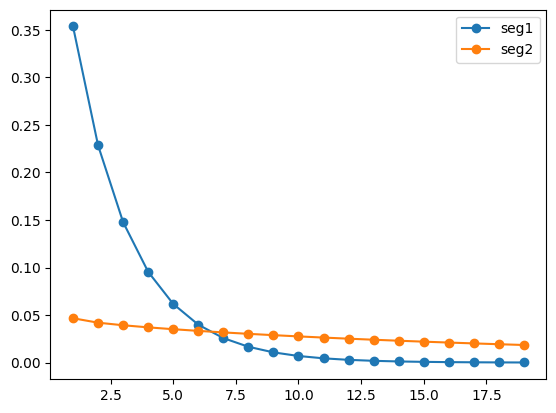

In [335]:
plt.plot(t, ll1, marker="o", label = 'seg1')
plt.plot(t, ll2, marker="o", label = 'seg2')
plt.legend()
plt.show()

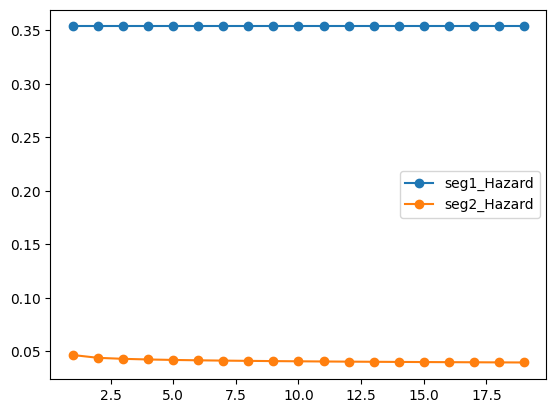

In [336]:
plt.plot(t, hazard1, marker="o", label = 'seg1_Hazard')
plt.plot(t, hazard2, marker="o", label = 'seg2_Hazard')
plt.legend()
plt.show()

Generally, we see an increasing trend for Hazard of Seg2, which indicates that the likelihood increases, while the Hazard of Seg1 remains like a constant, showing how it independent of the time. From graph 1, we also see change of seg 1 more obvious, while change of seg 2 is more depend on situation at each time period and can have less obvious changes. Thus we say seg 1 might represents simple or common applications, while seg 2 represents more unusual and complex applications.

In [325]:
beta

array([ 0.06383932,  0.69263949,  2.01898564, -0.53864311])

In [337]:
# Having X contains either 0 or 1, to maximize p for seg1, we want the exp term as small as possible, which means we want the X*beta as large as possible. Looking at the aigns of beta, we have X as:
X = np.array([1, 1, 1, 0]) 
p = 1 / (1 + np.exp(-(X @ beta)))
p

0.9413354783662998

In [338]:
# For seg2 we want to maximize 1-p, meaning we want to minimize p. Thus we have:
X2 = np.array([0, 0, 0, 1])
p_w = 1 - (1 / (1 + np.exp(-(X2 @ beta))))
p_w

0.6314967146499646

In [328]:
# For New, Basic, Bussiness we have X as:
X = np.array([1, 0, 0, 0])
p_p2 = 1 / (1 + np.exp(-(X @ beta)))
print("The porbability it belongs to seg 1 is:", p_p2)

The porbability it belongs to seg 1 is: 0.5159544114079794


In [339]:
p_7_seg1 = np.exp(-lambda1 * 6) - np.exp(-lambda1 * 7)
p_7_seg2 = np.exp(- (6 / lambda2) ** c2) - np.exp(-(7 / lambda2) ** c2)
p_pos = (p_p2 * p_7_seg1) / (p_p2 * p_7_seg1 + (1 - p_p2) * p_7_seg2)
print("The porbability it belongs to seg 1 known day 7 is:", p_pos)

The porbability it belongs to seg 1 known day 7 is: 1.0


# Part 3 [6 pts]

For our last task, we will estimate a multinomial logit model for predicting application **Status**, given the same three covariates as above. The options are `Issued` (0, baseline), `Denied` (1), and `Withdrawn` or `Pending` (2).

You should just use the built-in `mnlogit()` function from `statsmodels`. There should be **eight** parameters in total; show the estimated model summary.

In [330]:
License['Status_Match'] = License['Status'].map({'Issued': 0, 'Denied': 1, 'Withdrawn': 2, 'Pending': 2})

In [331]:
model = mnlogit("Status_Match~LT_Ind + AT_Re + AC_Spe", License).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.158060
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:           Status_Match   No. Observations:                 9887
Model:                        MNLogit   Df Residuals:                     9879
Method:                           MLE   Df Model:                            6
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                 0.08161
Time:                        21:32:04   Log-Likelihood:                -1562.7
converged:                       True   LL-Null:                       -1701.6
Covariance Type:            nonrobust   LLR p-value:                 4.787e-57
==================================================================================
Status_Match=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0805      0.108    -28.475      0.000      -3.293      -2.868
LT_Ind             0.6714      0.125      5.378      0.000       0.427       0.916
AT_Re             -1.5110      0.125    -12.126      0.000      -1.755      -1.267
AC_Spe             0.6066      0.119      5.096      0.000       0.373       0.840
----------------------------------------------------------------------------------
Status_Match=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.3637      0.223    -19.593      0.000      -4.800      -3.927
LT_Ind             0.3512      0.295      1.190      0.234      -0.227       0.930
AT_Re             -2.1708      0.333     -6.523      0.000      -2.823      -1.519
AC_Spe             0.2669      0.281      0.950      0.342      -0.284       0.818
==================================================================================
"""

# Part 4 [8 pts]

The newly estimated choice model gives us a categorial distribution over the possible outcomes for each kind of application submitted.

* Remember that the parameters of the baseline option (`Issued`) are all $0$ by default. Suppose we have two nearly identical applications that differ in just one of their features. For each feature $k$, what do the coefficients $\hat\beta_{1k}$ and $\hat\beta_{2k}$ tell you about the relative chances of the two applications resulting in `Issued` or not `Issued` status?

* Iterate through the different combinations of application features, and identify the ones that give the highest probability of an application being 1) issued, 2) denied, or 3) otherwise. Also report these respective probabilities.

For $\hat\beta_{1k}$ and $\hat\beta_{2k}$, we have that if $\hat\beta_{1k}$ for certain feature k, like ApplicationType, as Renewal, and if the beta here is negative, we know it's likely issued rather than denied. Similarly, for example if we have $\hat\beta_{2k}$, say k is Individual, we will say it's more likely withdraw/pending rather than issued.

In [332]:
results = []
possible_com = [
    [0, 0, 0], 
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0], 
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 1]
]

for com in possible_com:
    ind, re, spe = com
    X = np.array([1, ind, re, spe])
    iss = 0
    den = model.params[0] @ X
    other = model.params[1] @ X
    p = np.exp([iss, den, other]) / np.sum(np.exp([iss, den, other]))
    results.append({
        'Individual': ind, 
        'Renewal': re,
        'Special': spe,
        'Issued': p[0],
        'Denied': p[1],
        'Otherwise': p[2]
    })

results_df = pd.DataFrame(results)
high_prob_iss = results_df.loc[results_df['Issued'].idxmax()]
high_prob_den = results_df.loc[results_df['Denied'].idxmax()]
high_prob_other = results_df.loc[results_df['Otherwise'].idxmax()]


In [333]:
print("Highest for Issued:\n", high_prob_iss, "\nHighest for Denied:\n", high_prob_den, "\nHighest for Otherwise:\n", high_prob_other)

Highest for Issued:
 Individual    0.000000
Renewal       1.000000
Special       0.000000
Issued        0.988542
Denied        0.010022
Otherwise     0.001436
Name: 2, dtype: float64 
Highest for Denied:
 Individual    1.000000
Renewal       0.000000
Special       1.000000
Issued        0.841390
Denied        0.138735
Otherwise     0.019875
Name: 5, dtype: float64 
Highest for Otherwise:
 Individual    1.000000
Renewal       0.000000
Special       1.000000
Issued        0.841390
Denied        0.138735
Otherwise     0.019875
Name: 5, dtype: float64
